# **Reddit Scraping**

In [ ]:
import requests
import pandas
import numpy
import praw
from praw.models import MoreComments
import datetime
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import lmdicttest as test #Loughran-McDonald Master Dictionary sentiment analysis file
from ast import literal_eval
import time
import csv
import json

### Dr. Carvalho: For testing purposes, change the values below. Those are the values we used but that would take about 90-100 minutes to run due to rate limits.
post_limit = 1000 #The number of posts collected from each subreddit.
ticker_limit = 20 #The number of tickers to be analyzed. The top n amount will be used.

#Initiate reddit instance
reddit = praw.Reddit(
    client_id="nBo_LmV3NWcTsX-clcygDA",
    client_secret="rCmm5ggUymDih00sh0XzaOZM3obRiw",
    user_agent="Stock Bot ISA 414",
    username="ISA414Stocks",
    password="welovearthur",
)


commentlist = []
#NLTK Vader sentiment analysis to provide more insight
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

#User blacklist filters out bots that automatically comment on every post.
#Ticker blacklist filters out some common phrases that would appear as stock tickers.
user_blacklist = ["AutoModerator", "VisualMod"]
ticker_blacklist = ["CEO", "CFO", "COO", "ROFL", "LOL", "LMAO", "COVI", "WSB", "OP", "DD", "SEC", "USD", "SMH", "EU", "IRA", "EPS", "CNN", "USA", "YTD", "GDP", "FED", "MBA", "US", "SUCK", "BUY", "SELL", "ARE", "AI", "XXX", "XXXX", "POC", "POS", "YOLO", "IDK", "LGBT", "IPO", "OTC", "FML", "ETF"]

#This function retrieves all comment data from reddit and puts it into a list
def get_rdata(subr):
    subreddit = reddit.subreddit(subr)
    for submission in subreddit.new(limit=post_limit): #Limit is the amount of posts it will look through
        for top_level_comment in submission.comments:
            if isinstance(top_level_comment, MoreComments): #Some posts have so many comments that there is an option to show more of them. This ignores that.
                continue
            if top_level_comment.author in user_blacklist: #Checks comment author against User Blacklist
                continue
            else:
                hits = re.finditer(("([A-Z]{2,4})|(\$[A-z]{1,4})"), top_level_comment.body) #Finds text in the comment that appears to be a stock ticker
                tickers = [m.group(0) for m in hits]
                tickers = [re.sub("\$", "", i) for i in tickers] #Removes the '$' from in front of some tickers
                tickers = [x.upper() for x in tickers] #Makes all tickers uppercase
                for idx, tick in enumerate(tickers): #Changes blacklisted tickers to blanks
                    if tick in ticker_blacklist:
                        tickers[idx] = ""
                    else:
                        continue
                tickers_clean = []
                [tickers_clean.append(x) for x in tickers if x not in tickers_clean] #Adds the cleaned tickers to a list

                sentiment_score = test.tone_count_with_negation_check(test.lmdict,top_level_comment.body) #Gets LM sentiment score for each comment
                sentscore2 = sia.polarity_scores(top_level_comment.body)['compound'] #Gets NLTK Vader sentiment score for each comment
                templist = [top_level_comment.id,top_level_comment.body,top_level_comment.score,datetime.datetime.utcfromtimestamp(top_level_comment.created_utc), sentiment_score, str(tickers_clean), sentscore2, subreddit.display_name] #Puts all the data for this comment into a list
                commentlist.append(templist) #Appends the comment data to the list of others
        time.sleep(1) #Wait one second

#Run through each desired subreddit.
get_rdata("wallstreetbets")
get_rdata("stocks")
get_rdata("investing")


# **Data Preprocessing**

In [ ]:
#Turn the comment list into a dataframe
comments_df = pandas.DataFrame(commentlist, columns = ["ID","Comment","Score","DateTime","LM_Sentiment", "Tickers", "NLTK_Sentiment", "Subreddit"]).drop_duplicates().reset_index(drop=True)

new_index = comments_df.set_index("ID") #Set comment ID as the index
new_index['Tickers'] = new_index['Tickers'].apply(literal_eval) #I don't remember exactly what this does but I needed it to do the next line
new_index = new_index.explode("Tickers") #Creates multiple rows from comments that have multiple tickers found in them

new_index["Date"] = pandas.to_datetime(new_index['DateTime']).dt.date #Change the format of datetime to date
new_index = new_index.drop(columns = ['DateTime', 'Comment']) #Drop unused columns
tick_counts = pandas.DataFrame(new_index.value_counts(['Tickers']), columns=['Count']) #Create a count of the number of time

ticker_analysis = new_index.groupby(['Subreddit','Date','Tickers']).agg(['mean', 'count']) #Group by and aggregate the data, per subreddit, per day, per ticker
ticker_analysis.columns = [ '_'.join(str(i) for i in col) for col in ticker_analysis.columns] #Rename some columns by replacing spaces with underscores
ticker_analysis.reset_index(inplace=True)
ticker_analysis = ticker_analysis.drop(columns = ['Score_count','LM_Sentiment_count']).rename(columns={'NLTK_Sentiment_count':'Ticker_count'}) #Drop redundent columns
ticker_analysis = ticker_analysis[ticker_analysis['Tickers'] != ""] #Remove rows that don't contain tickers
#Here is a break point that would allow you to get all reddit data by exporting ticker_analysis.

reddit_data = ticker_analysis

reddit_data['Date'] = pandas.to_datetime(reddit_data['Date'])
df_date_filter = reddit_data[(reddit_data['Date'] >= '2022-04-28')] #Filter to only include data from the past week

df_sub = df_date_filter[["Tickers", "Ticker_count"]] #Subset data
top_tickers = df_sub.groupby(['Tickers']).sum().sort_values('Ticker_count', ascending=False).nlargest(ticker_limit, 'Ticker_count').reset_index() #Get only the top 20 most talked about tickers

ticker_list = top_tickers.iloc[:, 0] #Make a series of just the top tickers

week_data = df_date_filter.loc[reddit_data['Tickers'].isin(ticker_list)].reset_index(drop=True) #Subset data of just past week and top tickers

ticker_list = week_data['Tickers'].tolist()

def distinct(lst): #Get just the unique tickers into a list
    unique_list = []
    for x in lst:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

stocks = distinct(ticker_list)

stock_data = []
for stock_symbol in stocks: #Query the Alpha Vantage API to get stock daily time series data
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+stock_symbol+'&apikey=ESV637GM8CGOY9J8'
    r = requests.get(url)
    data = r.json()
    stock_data.append(data)
    time.sleep(13) #The rate limit for the free version is 5 requests per minute and 500 per day.

x = 0
iters = len(stock_data)
while x < iters:
    try:
        stock_data[x]['Meta Data']
    except KeyError:
        stock_data.remove(stock_data[x])
        iters = iters-1
    x=x+1

x = 0
stock_week = []
while x < len(stock_data): #Access the json returned by the API to format stock info
   tick = stock_data[x]["Meta Data"]["2. Symbol"] #Gets stock ticker
   for key, value in stock_data[x]["Time Series (Daily)"].items():
        key_item = key
        open_item = float(value["1. open"]) #Gets open price
        close_item = float(value["4. close"]) #Gets close price
        percent_change = (close_item-open_item)/open_item #Calculates percent change
        temp_week = [tick, key_item,open_item, close_item, percent_change]
        stock_week.append(temp_week) #Adds all data to a list
   x=x+1

stock_df = pandas.DataFrame(stock_week, columns=["Tickers", "Date", "Open_Price", "Close_Price", "Percent_Change"])
stock_df["Date"] = pandas.to_datetime(stock_df['Date'])
stock_df = stock_df[(stock_df['Date'] >= '2022-04-28')].reset_index(drop=True) #Price data is filtered to just be the past week. This was hardcoded for collection but could easily be changed.
week_data["Date"] = pandas.to_datetime(week_data['Date'])

finished_data = pandas.merge(stock_df, week_data, on=['Tickers','Date']) #Reddit data and price data is joined together.

finished_data.to_csv('final_data.csv')

# **Final Project Analysis and Evaluation Code**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

# read in data
df = pd.read_csv('final_data.csv')
# Remove FOMC since it is not publicly traded 
df = df[df['Tickers'] != 'FOMC']

In [59]:
df1 = df[['NLTK_Sentiment_mean','Percent_Change']] # Subset the data
pearsCorr = df1.corr() # Pearson Correlation 
print(pearsCorr)

                     NLTK_Sentiment_mean  Percent_Change
NLTK_Sentiment_mean             1.000000       -0.013202
Percent_Change                 -0.013202        1.000000


In [68]:
# built the model using Statsmodel
Y = df['Percent_Change']
X = df['NLTK_Sentiment_mean']
# add a column for the constant
X = sm.add_constant(X)
# running the model
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()

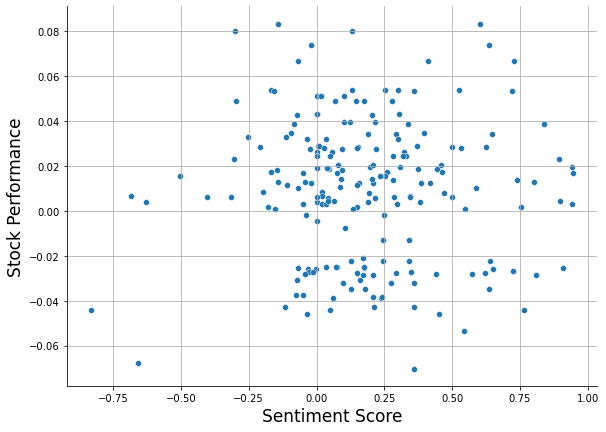

In [69]:
# test the linearity assumption
scatter = sns.relplot(data=df, x='NLTK_Sentiment_mean', y='Percent_Change', kind='scatter', height=6, aspect=1.4)
scatter.set_axis_labels(x_var="Sentiment Score", y_var="Stock Performance", fontsize=17)
plt.grid()

eval_env: 1


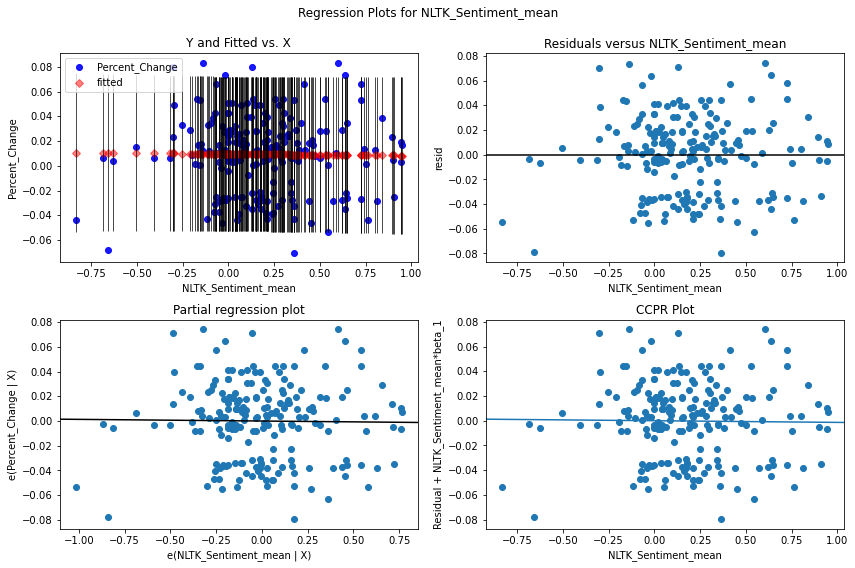

In [70]:
fig = plt.figure(figsize=(12,8)) # define the figure size for the regression plot matrix
fig = sm.graphics.plot_regress_exog(model_result, 'NLTK_Sentiment_mean', fig=fig) # produce the regression plots


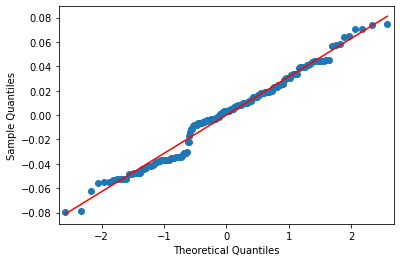

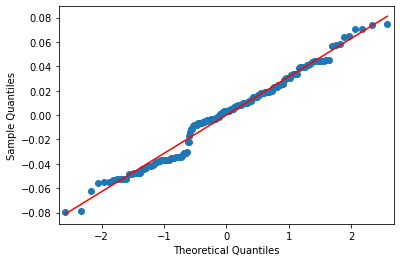

In [71]:
# test the normality assumption
sm.qqplot(model_result.resid, line='s')


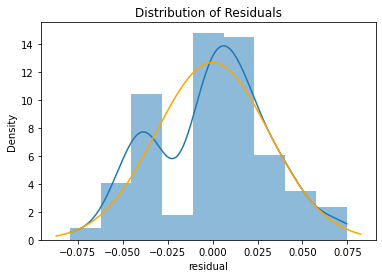

In [72]:
mu, std = stats.norm.fit(model_result.resid)
fig, ax = plt.subplots()
sns.histplot(x=model_result.resid, ax=ax, stat='density',  linewidth=0, kde=True)
ax.set(title='Distribution of Residuals', xlabel='residual')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
sns.lineplot(x=x, y=p, color='orange', ax=ax)
plt.show()

In [73]:
# evaluating model parameters, p-value
print(model_result.summary())

                            OLS Regression Results                            
Dep. Variable:         Percent_Change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.03469
Date:                Fri, 06 May 2022   Prob (F-statistic):              0.852
Time:                        13:47:44   Log-Likelihood:                 410.34
No. Observations:                 201   AIC:                            -816.7
Df Residuals:                     199   BIC:                            -810.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096    